# AML Project 2 Group 1 

# Github repo：
https://github.com/Yifan-Zang/GR5074_Project2_MedicalImageClassification.git
# group member：
1. Xingyu Shi xs2557
2. Yifan Zang yz4870
3. Chunlin An ca2965

# Introduction & Dataset Overview

Dataset: the dataset consists of a total of 15153 colored radiography images of patients across three conditions: COVID, normal, and pneumonia.

In [1]:
import os
cwd = os.getcwd()
print(cwd)

C:\Users\1\AML_P2


In [3]:
os.add_dll_directory(r"C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v11.2\bin")

<AddedDllDirectory('C:\\Program Files\\NVIDIA GPU Computing Toolkit\\CUDA\\v11.2\\bin')>

In [5]:
# run on GPU
import tensorflow as tf
print("Built with CUDA:", tf.test.is_built_with_cuda())
try:
    from tensorflow.python.platform import build_info as tf_build_info
    print("TF build info:", tf_build_info.build_info.get("cuda_version"),
          tf_build_info.build_info.get("cudnn_version"))
except Exception as e:
    print("build_info not available:", e)

print("Visible GPUs:", tf.config.list_physical_devices("GPU"))

Built with CUDA: True
TF build info: 64_112 64_8
Visible GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [7]:
import tensorflow as tf
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

In [9]:
import zipfile
import os

zip_path = r"C:\Users\1\AML_P2\COVID-19_Radiography_Dataset.zip"
extract_dir = r"C:\Users\1\AML_P2\MLP2_QMSS\dataset"

os.makedirs(extract_dir, exist_ok=True)

# unzip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

In [14]:
import sys
import time
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
import zipfile

%matplotlib inline


from tensorflow.python.keras.utils import np_utils
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.applications import VGG19, ResNet50, InceptionV3

# Exploratory Data Analysis (EDA)

In [19]:
# Extracting all filenames iteratively
base_path = r"C:\Users\1\AML_P2\MLP2_QMSS\dataset\COVID-19_Radiography_Dataset"
categories = ['COVID/images', 'Normal/images', 'Viral Pneumonia/images']

# load file names to fnames list object
fnames = []
for category in categories:
    image_folder = os.path.join(base_path, category)
    file_names = os.listdir(image_folder)
    full_path = [os.path.join(image_folder, file_name) for file_name in file_names]
    fnames.append(full_path)

In [21]:
# describe the dataset
#print('number of images for each category:', [len(f) for f in fnames])
print("sample file name: ", fnames[0][0]) #examples of file names

img_counts = pd.DataFrame()
img_counts['category'] = categories
img_counts['count'] = [len(f) for f in fnames]
display(img_counts)

sample file name:  C:\Users\1\AML_P2\MLP2_QMSS\dataset\COVID-19_Radiography_Dataset\COVID/images\COVID-1.png


,category,count
0,COVID/images,3616
1,Normal/images,10192
2,Viral Pneumonia/images,1345


Here we can see that the distribution of number of images for each category is uneven, with most images belonging to the 'normal' category, and the least belonging to the 'pneumonia' category'.

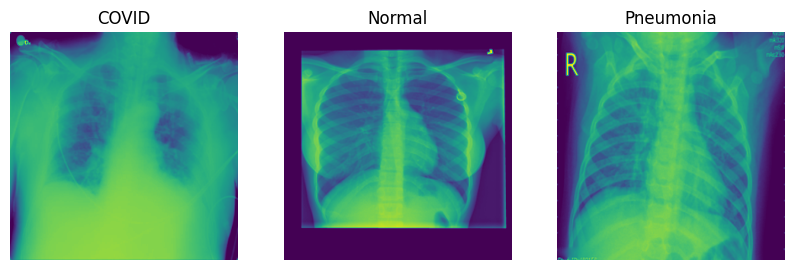

In [24]:
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import random
import matplotlib.image as mpimg

# Load the image
cvdimg = mpimg.imread(fnames[0][0])
nrmimg = mpimg.imread(fnames[1][0])
pneimg = mpimg.imread(fnames[2][0])

# Display the three sample images

f, axarr = plt.subplots(1, 3, figsize=(10,4))  # 1 row, 3 columns

axarr[0].imshow(cvdimg)
axarr[0].set_title("COVID")

axarr[1].imshow(nrmimg)
axarr[1].set_title("Normal")

axarr[2].imshow(pneimg)
axarr[2].set_title("Pneumonia")

for ax in axarr:
    ax.axis('off')

plt.show()

In [26]:
# Write preprocessor that will match up with model's expected input shape.
from keras.preprocessing import image
import numpy as np
from PIL import Image

def preprocessor(img_path):
        img = Image.open(img_path).convert("RGB").resize((192,192)) # import image, make sure it's RGB and resize to height and width you want.
        img = (np.float32(img)-1.)/(255-1.) # min max transformation
        img=img.reshape((192,192,3)) # Create final shape as array with correct dimensions for Keras
        return img



#Try on single file (imports file and preprocesses it to data with following shape)
preprocessor(r'C:\Users\1\AML_P2\MLP2_QMSS/dataset/COVID-19_Radiography_Dataset/COVID/images/COVID-1003.png').shape

(192, 192, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.003937008..0.8425197].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.003937008..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.003937008..1.0].


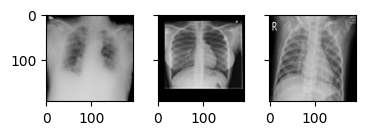

In [28]:
# sample images after preprocessing

im1 =preprocessor(fnames[0][0]) # COVID-positive image
im2 =preprocessor(fnames[1][0]) # normal image
im3 =preprocessor(fnames[2][0]) # viral pneumonia image

fig = plt.figure(figsize=(4., 4.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 3),  # creates 2x2 grid of axes
                 axes_pad=0.25,  # pad between axes in inch.
                 )

for ax, im in zip(grid, [im1, im2, im3]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)
plt.show()

As our data is heavily imbalanced, with the 'normal' class having almost 8 times more samples than the pneumonia class and about 3 times more than the COVID class, we would need to rebalance the dataset.
We can conduct undersampling to have the sample number match the smallest class, but that way we would lose valuable data and our model would also have weaker generalizability. For similar reasons we would also want to avoid oversampling, which simply duplicates new samples from our smallest class and can result in the model overfitting. A better approach would be to apply data augmentation on the smallest class, while also calculating class weights by assigning higher loss weights to the minority classes during training, which is especially effective in training neural networks.


However, due to limitation of computing power, we will use the undersampling technique.

In [31]:
#Reduce number of images to first 1345 for each category
fnames[0]=fnames[0][0:1344]
fnames[1]=fnames[1][0:1344]
fnames[2]=fnames[2][0:1344]

In [33]:
#Import image files iteratively and preprocess them into array of correctly structured data

# Create list of file paths
image_filepaths=fnames[0]+fnames[1]+fnames[2]

# Iteratively import and preprocess data using map function

# map functions apply your preprocessor function one step at a time to each filepath
preprocessed_image_data=list(map(preprocessor,image_filepaths ))

# Object needs to be an array rather than a list for Keras (map returns to list object)
X= np.array(preprocessed_image_data) # Assigning to X to highlight that this represents feature input data for our model

In [34]:
print(len(X) ) #same number of elements as filenames
print(X.shape ) #dimensions now 192,192,3 for all images
print(X.min().round() ) #min value of every image is zero
print(X.max() ) #max value of every image is one

4032
(4032, 192, 192, 3)
-0.0
1.0


In [35]:
# Create y data made up of correctly ordered labels from file folders
from itertools import repeat

# Recall that we have five folders with the following number of images in each folder
#...corresponding to each flower type

print('number of images for each category:', [len(f) for f in fnames])
covid=list(repeat("COVID", 1344))
normal=list(repeat("NORMAL", 1344))
pneumonia=list(repeat("PNEUMONIA", 1344))

#combine into single list of y labels
y_labels = covid+normal+pneumonia

#check length, same as X above
print(len(y_labels) )

# Need to one hot encode for Keras.  Let's use Pandas

import pandas as pd
y=pd.get_dummies(y_labels)

display(y)

number of images for each category: [1344, 1344, 1344]
4032


,COVID,NORMAL,PNEUMONIA
0,True,False,False
1,True,False,False
2,True,False,False
3,True,False,False
4,True,False,False
...,...,...,...
4027,False,False,True
4028,False,False,True
4029,False,False,True
4030,False,False,True


In [39]:
# Train test split resized images
import numpy as np
from sklearn.model_selection import train_test_split

y_idx = np.argmax(y.values, axis=1) if hasattr(y, "values") else np.argmax(y, axis=1)

# index
idx = np.arange(len(X))

#using index to split
train_idx, test_idx = train_test_split(
    idx, test_size=0.32, stratify=y_idx, random_state=1987
)

X_train = np.take(X, train_idx, axis=0)
X_test  = np.take(X, test_idx,  axis=0)
y_train = np.take(y.values if hasattr(y, "values") else y, train_idx, axis=0)
y_test  = np.take(y.values if hasattr(y, "values") else y, test_idx,  axis=0)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(2741, 192, 192, 3) (1291, 192, 192, 3)
(2741, 3) (1291, 3)


To explore which factors may be related to the classification of the three conditions, we tried comparing the average brightness images across each category.

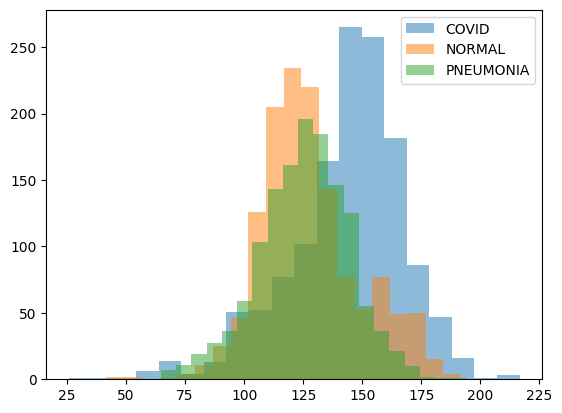

In [44]:
# plot distribution of brightness of images in each category

from PIL import ImageStat

# define image brightness function that converts images to greyscale

def brightness(im_file):
  im = Image.open(im_file).convert('L')
  stat = ImageStat.Stat(im)
  return stat.mean[0]

# iterate through data

covid_brightness=list(map(brightness, fnames[0]))
normal_brightness=list(map(brightness, fnames[1]))
pneumonia_brightness=list(map(brightness, fnames[2]))

# plot distribution of brightness

plt.hist(covid_brightness, bins=20, alpha=0.5, label='COVID')
plt.hist(normal_brightness, bins=20, alpha=0.5, label='NORMAL')
plt.hist(pneumonia_brightness, bins=20, alpha=0.5, label='PNEUMONIA')
plt.legend(loc='upper right')


It can be seen from the histogram that while the average brightness for "normal"-labeled images is normally distributed around 125, the distribution of "covid"-labeled images is skewed left, and the distributino of "pneumonia"-labeled images is skewed right. To test this, we calculated the mean and sd for each category, and then conducted a one-way ANOVA to see if there is a significant differece across three groups.

In [45]:
print("covid image average brightness: ", np.mean(covid_brightness), "standard deviation: ", np.std(covid_brightness))
print("normal image average brightness: ", np.mean(normal_brightness), "standard deviation: ", np.std(normal_brightness))
print("pneumonia image average brightness: ", np.mean(pneumonia_brightness), "standard deviation: ", np.std(pneumonia_brightness))

covid image average brightness:  143.66979247229312 standard deviation:  24.2521628644205
normal image average brightness:  127.91936884428159 standard deviation:  21.1949127758166
pneumonia image average brightness:  125.36907965268578 standard deviation:  18.98096347112496


In [46]:
# conduct ANOVA for three averages

from scipy.stats import f_oneway

f_statistic, p_value = f_oneway(covid_brightness, normal_brightness, pneumonia_brightness)

print(f"F-statistic: {f_statistic}")
print(f"P-value: {p_value}")

F-statistic: 283.2191215491495
P-value: 8.171210395007046e-116


Based on the ANOVA, it can be seen that the average brightness is significantly different across the three types of radiography images.

Through modeling, we can more accurately classify radiography images to match their respective conditions. This is extremely helpful to support clinical descisions through a quicker identification of potential critical conditions that require more urgent attention. It can serve as a powerful screening tool for clinics where radiologists may be understaffed. Analyzing and identifying feature importance in these models can also improve understanding on potentially important biomarkers in these diseases.

# Baseline CNN Model

This baseline CNN consists of:
- 3 Convolutional blocks (Conv2D + MaxPooling + Dropout)
- Fully connected layers for classification
- Total of ~1.8M parameters

Architecture choices:
- ReLU activation for non-linearity
- MaxPooling for downsampling
- Dropout for regularization to prevent overfitting
- Softmax output for multi-class classification

In [59]:
# load data
import pickle

class NpCompatUnpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module.startswith("numpy._core"):
            module = module.replace("numpy._core", "numpy.core")
        return super().find_class(module, name)

def load_pickle_compat(path):
    with open(path, 'rb') as f:
        return NpCompatUnpickler(f).load()

X_train = load_pickle_compat(r'C:\Users\1\AML_P2\X_train.pkl')
y_train = load_pickle_compat(r'C:\Users\1\AML_P2\y_train.pkl')
X_test  = load_pickle_compat(r'C:\Users\1\AML_P2\X_test.pkl')
y_test  = load_pickle_compat(r'C:\Users\1\AML_P2\y_test.pkl')

import numpy as np
import pandas as pd

np.savez_compressed(r'C:\Users\1\AML_P2\data_train.npz', X=X_train, y=y_train.values)
np.savez_compressed(r'C:\Users\1\AML_P2\data_test.npz',  X=X_test,  y=y_test.values)

dtr = np.load(r'C:\Users\1\AML_P2\data_train.npz')
dte = np.load(r'C:\Users\1\AML_P2\data_test.npz')
X_train, y_train = dtr['X'], dtr['y']
X_test,  y_test  = dte['X'], dte['y']

In [60]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

**Build Baseline CNN Architecture**

In [62]:
def create_baseline_cnn(input_shape=(192, 192, 3), num_classes=3):
    """
    Create a baseline CNN architecture for medical image classification.

    Parameters:
    - input_shape: tuple, shape of input images (height, width, channels)
    - num_classes: int, number of output classes

    Returns:
    - model: compiled Keras model
    """

    model = Sequential(name='Baseline_CNN')

    # First Convolutional Block
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu',
                     padding='same', input_shape=input_shape, name='conv1'))
    model.add(MaxPooling2D(pool_size=(2, 2), name='pool1'))
    model.add(Dropout(0.25, name='dropout1'))

    # Second Convolutional Block
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu',
                     padding='same', name='conv2'))
    model.add(MaxPooling2D(pool_size=(2, 2), name='pool2'))
    model.add(Dropout(0.25, name='dropout2'))

    # Third Convolutional Block
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu',
                     padding='same', name='conv3'))
    model.add(MaxPooling2D(pool_size=(2, 2), name='pool3'))
    model.add(Dropout(0.25, name='dropout3'))

    # Flatten and Fully Connected Layers
    model.add(Flatten(name='flatten'))
    model.add(Dense(256, activation='relu', name='fc1'))
    model.add(Dropout(0.5, name='dropout4'))
    model.add(Dense(num_classes, activation='softmax', name='output'))

    return model

In [63]:
# Create the model
baseline_cnn = create_baseline_cnn(input_shape=(192, 192, 3), num_classes=3)

# Display model architecture
baseline_cnn.summary()

Model: "Baseline_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 192, 192, 32)      896       
                                                                 
 pool1 (MaxPooling2D)        (None, 96, 96, 32)        0         
                                                                 
 dropout1 (Dropout)          (None, 96, 96, 32)        0         
                                                                 
 conv2 (Conv2D)              (None, 96, 96, 64)        18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 48, 48, 64)        0         
                                                                 
 dropout2 (Dropout)          (None, 48, 48, 64)        0         
                                                                 
 conv3 (Conv2D)              (None, 48, 48, 128)      

**Compile and Configure Training**

Model Configuration:
- Loss Function: categorical_crossentropy (for multi-class classification)
- Optimizer: Adam （learning rate of 0.001）
- Metrics: accuracy for performance evaluation

Callbacks:
- EarlyStopping: stops training if validation loss doesn't improve for 5 epochs
- ReduceLROnPlateau: reduces learning rate when validation loss plateaus

In [70]:
# Compile the model
baseline_cnn.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Define callbacks for training
callbacks_baseline = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
]

**Train the Baseline CNN**

Training Configuration:
- Epochs: 10 (with early stopping)
- Batch size: 32
- Validation split: 20% of training data

In [72]:
history_baseline = baseline_cnn.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=32,
    callbacks=callbacks_baseline,
    verbose=1
)

Epoch 1/10
69/69 [==============================] - 10s 26ms/step - loss: 0.8819 - accuracy: 0.6250 - val_loss: 0.4580 - val_accuracy: 0.7960 - lr: 0.0010
Epoch 2/10
69/69 [==============================] - 1s 20ms/step - loss: 0.3909 - accuracy: 0.8449 - val_loss: 0.3142 - val_accuracy: 0.8743 - lr: 0.0010
Epoch 3/10
69/69 [==============================] - 1s 20ms/step - loss: 0.2904 - accuracy: 0.8828 - val_loss: 0.3076 - val_accuracy: 0.9016 - lr: 0.0010
Epoch 4/10
69/69 [==============================] - 1s 19ms/step - loss: 0.2419 - accuracy: 0.9033 - val_loss: 0.2566 - val_accuracy: 0.9089 - lr: 0.0010
Epoch 5/10
69/69 [==============================] - 1s 20ms/step - loss: 0.1843 - accuracy: 0.9266 - val_loss: 0.2244 - val_accuracy: 0.9199 - lr: 0.0010
Epoch 6/10
69/69 [==============================] - 1s 20ms/step - loss: 0.1546 - accuracy: 0.9389 - val_loss: 0.2286 - val_accuracy: 0.9326 - lr: 0.0010
Epoch 7/10
69/69 [==============================] - 1s 19ms/step - loss: 0.

**Evaluate Baseline CNN Performance**

In [126]:
# Evaluate on test set
test_loss_baseline, test_acc_baseline = baseline_cnn.evaluate(X_test, y_test, verbose=0)

print(f"Test Loss:     {test_loss_baseline:.4f}")
print(f"Test Accuracy: {test_acc_baseline:.4f} ({test_acc_baseline*100:.2f}%)")

# Get training and validation accuracy and loss for final epoch
final_train_acc = history_baseline.history['accuracy'][-1]
final_train_loss = history_baseline.history['loss'][-1]
final_val_acc = history_baseline.history['val_accuracy'][-1]
final_val_loss = history_resnet.history['val_loss'][-1]

print(f"\nFinal Training Accuracy:   {final_train_acc:.4f} ({final_train_acc*100:.2f}%)")
print(f"Final Validation Accuracy: {final_val_acc:.4f} ({final_val_acc*100:.2f}%)")

Test Loss:     0.1936
Test Accuracy: 0.9287 (92.87%)

Final Training Accuracy:   0.9763 (97.63%)
Final Validation Accuracy: 0.9454 (94.54%)


**Visualize Training History**

Plot training and validation loss & accuracy curves to assess model performance
and check for overfitting or underfitting

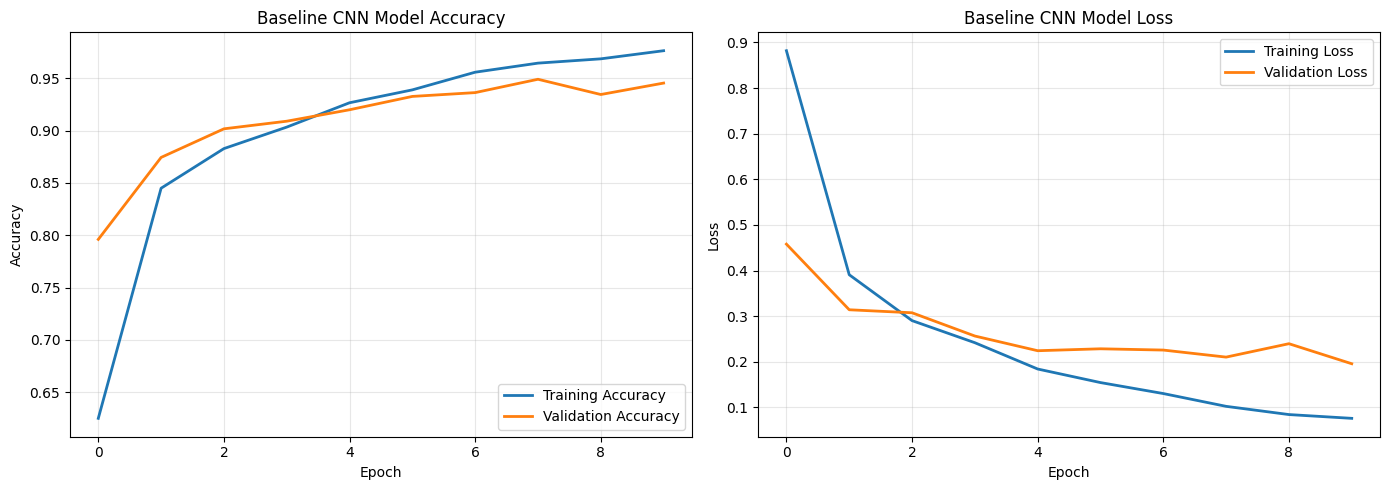


Training Summary:
Total epochs trained: 10
Best validation accuracy: 0.9490
Best validation loss: 0.1959


In [77]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training & validation accuracy
axes[0].plot(history_baseline.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[0].plot(history_baseline.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[0].set_title('Baseline CNN Model Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend(loc='lower right')
axes[0].grid(True, alpha=0.3)

# Training & validation loss
axes[1].plot(history_baseline.history['loss'], label='Training Loss', linewidth=2)
axes[1].plot(history_baseline.history['val_loss'], label='Validation Loss', linewidth=2)
axes[1].set_title('Baseline CNN Model Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nTraining Summary:")
print(f"Total epochs trained: {len(history_baseline.history['loss'])}")
print(f"Best validation accuracy: {max(history_baseline.history['val_accuracy']):.4f}")
print(f"Best validation loss: {min(history_baseline.history['val_loss']):.4f}")

In [128]:
# Save for comparison
perf_rows = []
perf_rows.append({
    'Model': 'BaselineCNN', # model name
    'Type': 'baseline', # model type
    'Train_Accuracy': float(final_train_acc), # final training accuracy
    'Val_Accuracy': float(final_val_acc), # final validation accuracy
    'Test_Accuracy': float(test_acc_baseline), # final test accuracy
    'Train_Loss': float(final_train_loss), # final training loss
    'Val_Loss': float(final_val_loss), # final validation loss
    'Test_Loss': float(test_loss_baseline) # final test loss
})

# Transfer Learning with ResNet

Transfer Learning:
1. Load ResNet50 pre-trained on ImageNet
2. Freeze the base convolutional layers (feature extractor)
3. Add custom classification layers
4. Fine-tune (maybe)


In [83]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [85]:
def create_resnet_transfer_model(input_shape=(192, 192, 3), num_classes=3, trainable_base=False):
    """
    Create ResNet50 model with transfer learning.

    Parameters:
    - input_shape: tuple, shape of input images
    - num_classes: int, number of output classes
    - trainable_base: bool, whether to fine-tune base layers

    Returns:
    - model: compiled Keras model
    """

    # Load pre-trained NesNet50 without top classification layer
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )

    # Freeze base model layers
    base_model.trainable = trainable_base

    # Add custom classification head
    x = base_model.output
    x = GlobalAveragePooling2D(name='global_avg_pool')(x)
    x = Dense(256, activation='relu', name='fc1')(x)
    x = Dropout(0.5, name='dropout1')(x)
    x = Dense(128, activation='relu', name='fc2')(x)
    x = Dropout(0.3, name='dropout2')(x)
    outputs = Dense(num_classes, activation='softmax', name='output')(x)

    # Create final model
    model = Model(inputs=base_model.input, outputs=outputs, name='ResNet50_Transfer')

    return model, base_model

In [87]:
# Create ResNet50 transfer learning model
resnet_model, resnet_base = create_resnet_transfer_model(
    input_shape=(192, 192, 3),
    num_classes=3,
    trainable_base=False
)

# Display model
resnet_model.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "ResNet50_Transfer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 198, 198, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 96, 96, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchN

**Preprocess Data for ResNet**

ResNet50 requires specific preprocessing:
- Input images should be in range [0, 255]
- Apply ImageNet preprocessing (mean subtraction and scaling)

Our data is currently in [0, 1], so we need to scale it back.

In [89]:
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess

# Prepare data for ResNet
X_train_resnet = resnet_preprocess((np.copy(X_train) * 255.0).astype('float32'))
X_test_resnet = resnet_preprocess((np.copy(X_test) * 255.0).astype('float32'))

print(f"Training data shape: {X_train_resnet.shape}")
print(f"Test data shape: {X_test_resnet.shape}")
print(f"Training data range: [{X_train_resnet.min():.2f}, {X_train_resnet.max():.2f}]")

Training data shape: (2741, 192, 192, 3)
Test data shape: (1291, 192, 192, 3)
Training data range: [-124.68, 151.06]


**Compile and Train ResNet Model**

Training Configuration for ResNet:
- Lower learning rate (0.0001)
- Same callbacks as baseline for fair comparison

In [91]:
# Compile the model
resnet_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Define callbacks
callbacks_resnet = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-8,
        verbose=1
    )
]

In [92]:
# Train the model
history_resnet = resnet_model.fit(
    X_train_resnet, y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=32,
    callbacks=callbacks_resnet,
    verbose=1
)

Epoch 1/10
69/69 [==============================] - 4s 42ms/step - loss: 0.9498 - accuracy: 0.6008 - val_loss: 0.3948 - val_accuracy: 0.8361 - lr: 1.0000e-04
Epoch 2/10
69/69 [==============================] - 2s 30ms/step - loss: 0.4976 - accuracy: 0.7824 - val_loss: 0.3238 - val_accuracy: 0.8579 - lr: 1.0000e-04
Epoch 3/10
69/69 [==============================] - 2s 29ms/step - loss: 0.4085 - accuracy: 0.8317 - val_loss: 0.2956 - val_accuracy: 0.8616 - lr: 1.0000e-04
Epoch 4/10
69/69 [==============================] - 2s 30ms/step - loss: 0.3407 - accuracy: 0.8577 - val_loss: 0.2812 - val_accuracy: 0.8707 - lr: 1.0000e-04
Epoch 5/10
69/69 [==============================] - 2s 28ms/step - loss: 0.3060 - accuracy: 0.8714 - val_loss: 0.2570 - val_accuracy: 0.8889 - lr: 1.0000e-04
Epoch 6/10
69/69 [==============================] - 2s 29ms/step - loss: 0.2815 - accuracy: 0.8846 - val_loss: 0.2417 - val_accuracy: 0.8907 - lr: 1.0000e-04
Epoch 7/10
69/69 [==============================] - 

**Evaluate ResNet Performance**

In [130]:
# Evaluate on the test set
test_loss_resnet, test_acc_resnet = resnet_model.evaluate(X_test_resnet, y_test, verbose=0)

print(f"Test Loss:     {test_loss_resnet:.4f}")
print(f"Test Accuracy: {test_acc_resnet:.4f} ({test_acc_resnet*100:.2f}%)")

# Get training and validation accuracy and loss
final_train_acc_resnet = history_resnet.history['accuracy'][-1]
final_train_loss_resnet = history_resnet.history['loss'][-1]
final_val_acc_resnet = history_resnet.history['val_accuracy'][-1]
final_val_loss_resnet = history_resnet.history['val_loss'][-1]

print(f"\nFinal Training Accuracy:   {final_train_acc_resnet:.4f} ({final_train_acc_resnet*100:.2f}%)")
print(f"Final Validation Accuracy: {final_val_acc_resnet:.4f} ({final_val_acc_resnet*100:.2f}%)")

Test Loss:     0.1598
Test Accuracy: 0.9342 (93.42%)

Final Training Accuracy:   0.9270 (92.70%)
Final Validation Accuracy: 0.9016 (90.16%)


In [132]:
# Save for comparison
perf_rows.append({
    'Model': 'ResNet',
    'Type': 'transfer',
    'Train_Accuracy': float(final_train_acc_resnet),
    'Val_Accuracy': float(final_val_acc_resnet),
    'Test_Accuracy': float(test_acc_resnet),
    'Train_Loss': float(final_train_loss_resnet),
    'Val_Loss': float(final_val_loss_resnet),
    'Test_Loss': float(test_loss_resnet)
})

**Visualize ResNet Training History**

Plot training curves for ResNet50

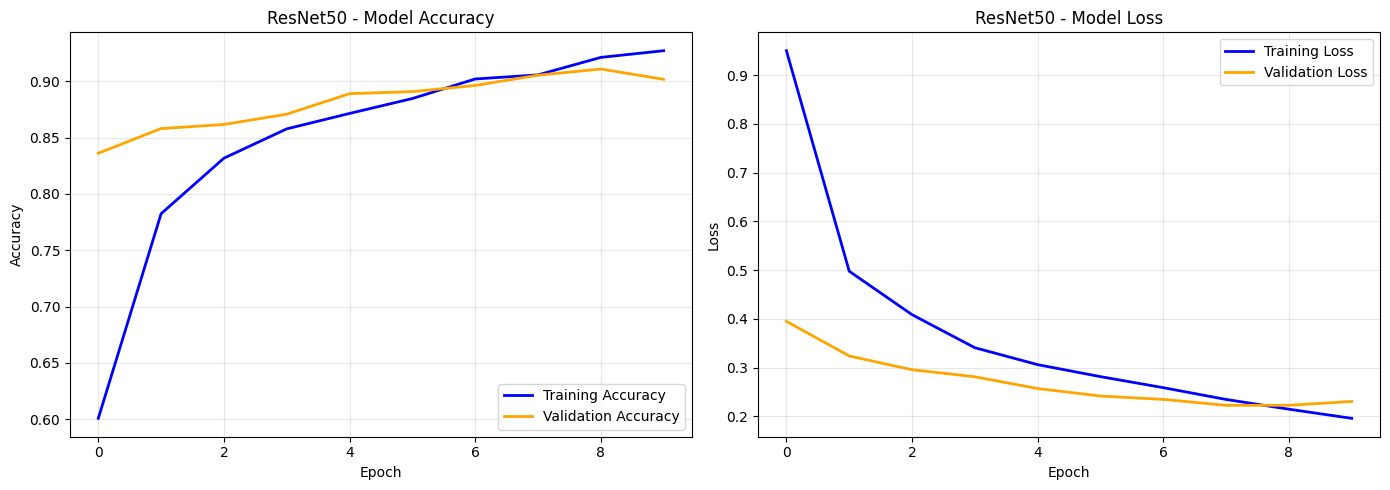

In [102]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training & validation accuracy
axes[0].plot(history_resnet.history['accuracy'], label='Training Accuracy', linewidth=2, color='blue')
axes[0].plot(history_resnet.history['val_accuracy'], label='Validation Accuracy', linewidth=2, color='orange')
axes[0].set_title('ResNet50 - Model Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend(loc='lower right')
axes[0].grid(True, alpha=0.3)

# Training & validation loss
axes[1].plot(history_resnet.history['loss'], label='Training Loss', linewidth=2, color='blue')
axes[1].plot(history_resnet.history['val_loss'], label='Validation Loss', linewidth=2, color='orange')
axes[1].set_title('ResNet50 - Model Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Additional 3 transfer model

# VGG16

This model applies transfer learning using the VGG16 architecture pre-trained on ImageNet as the convolutional feature extractor. All convolutional layers in the VGG16 base are frozen (trainable=False) to retain learned visual features while training a lightweight classification head on top. The input images are preprocessed with VGG’s standard preprocess_input (after rescaling to 0–255 and converting to float32) and resized to 192×192×3.

The model’s top layers consist of a GlobalAveragePooling2D layer to reduce spatial dimensions, a Dense(128, relu) layer to learn higher-level representations, a Dropout(0.3) layer to prevent overfitting, and a Dense(3, softmax) output layer for 3-class prediction.

The network is compiled with Adam optimizer (default learning rate 1e-3), categorical cross-entropy loss, and accuracy as the evaluation metric. During training, two callbacks are employed:

EarlyStopping(patience=5, restore_best_weights=True) — stops training if validation loss stops improving for 5 epochs and restores the best weights.

ReduceLROnPlateau(patience=3, factor=0.5, verbose=1) — halves the learning rate if validation loss remains stagnant for 3 epochs, helping the optimizer make finer updates near convergence.

Training is executed for up to 25 epochs with a batch size of 32 and an 80/20 validation split, allowing the model to learn efficiently while monitoring overfitting.

In [173]:
## VGG16
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input as vgg_preprocess
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# VGG16 data prepocessing(make a copy prevent trouble)
Xtr_vgg = vgg_preprocess((np.copy(X_train) * 255.0).astype('float32'))
Xte_vgg = vgg_preprocess((np.copy(X_test)  * 255.0).astype('float32'))

# model build
base_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(192,192,3))
for l in base_vgg.layers:
    l.trainable = False #using the pre-training weight,fix it to nontrainable


x = GlobalAveragePooling2D()(base_vgg.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x) #add dropout to prevent overfitting
out = Dense(3, activation='softmax')(x)
model_vgg16 = Model(inputs=base_vgg.input, outputs=out)

model_vgg16.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model_vgg16.summary())

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 192, 192, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 192, 192, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 192, 192, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 96, 96, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 96, 96, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 96, 96, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 48, 48, 128)       0   

In [174]:
# training and callbacks
cb = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(patience=3, factor=0.5, verbose=1)
]#define the callbacks: use earlystoping to reduce overfitting and learning rate adjustment to prevent divergence

history_vgg16 = model_vgg16.fit(
    Xtr_vgg, y_train,
    validation_split=0.2,
    epochs=25, batch_size=32,
    callbacks=cb, verbose=1
) #fit the model and print the process 

# evaluate 
best_epoch = np.argmax(history_vgg16.history['val_accuracy'])
#(the best epoch not neccessarily the last one (because use the early stopping)
best_train_acc  = history_vgg16.history['accuracy'][best_epoch]
best_val_acc    = history_vgg16.history['val_accuracy'][best_epoch]
best_train_loss = history_vgg16.history['loss'][best_epoch]
best_val_loss   = history_vgg16.history['val_loss'][best_epoch]

test_loss_vgg16, test_acc_vgg16 = model_vgg16.evaluate(Xte_vgg, y_test, verbose=0)

print(f"=== VGG16 Early-Stopped Performance ===")
print(f"Best Epoch: {best_epoch + 1}")
print(f"Training   Accuracy: {best_train_acc:.4f} | Loss: {best_train_loss:.4f}")
print(f"Validation Accuracy: {best_val_acc:.4f} | Loss: {best_val_loss:.4f}")
print(f"Test       Accuracy: {test_acc_vgg16:.4f} | Loss: {test_loss_vgg16:.4f}")

perf_rows.append({
    'Model': 'VGG16',
    'Type': 'transfer',
    'Train_Accuracy': float(best_train_acc),
    'Val_Accuracy': float(best_val_acc),
    'Test_Accuracy': float(test_acc_vgg16),
    'Train_Loss': float(best_train_loss),
    'Val_Loss': float(best_val_loss),
    'Test_Loss': float(test_loss_vgg16)
})


Epoch 1/25
69/69 [==============================] - 4s 44ms/step - loss: 0.7077 - accuracy: 0.7979 - val_loss: 0.2746 - val_accuracy: 0.8852 - lr: 0.0010
Epoch 2/25
69/69 [==============================] - 3s 39ms/step - loss: 0.2311 - accuracy: 0.9088 - val_loss: 0.2433 - val_accuracy: 0.9016 - lr: 0.0010
Epoch 3/25
69/69 [==============================] - 3s 39ms/step - loss: 0.1890 - accuracy: 0.9170 - val_loss: 0.1796 - val_accuracy: 0.9381 - lr: 0.0010
Epoch 4/25
69/69 [==============================] - 3s 41ms/step - loss: 0.1431 - accuracy: 0.9425 - val_loss: 0.2020 - val_accuracy: 0.9180 - lr: 0.0010
Epoch 5/25
69/69 [==============================] - 3s 39ms/step - loss: 0.1094 - accuracy: 0.9580 - val_loss: 0.1480 - val_accuracy: 0.9381 - lr: 0.0010
Epoch 6/25
69/69 [==============================] - 3s 39ms/step - loss: 0.0949 - accuracy: 0.9644 - val_loss: 0.1581 - val_accuracy: 0.9326 - lr: 0.0010
Epoch 7/25
69/69 [==============================] - 3s 38ms/step - loss: 0.0

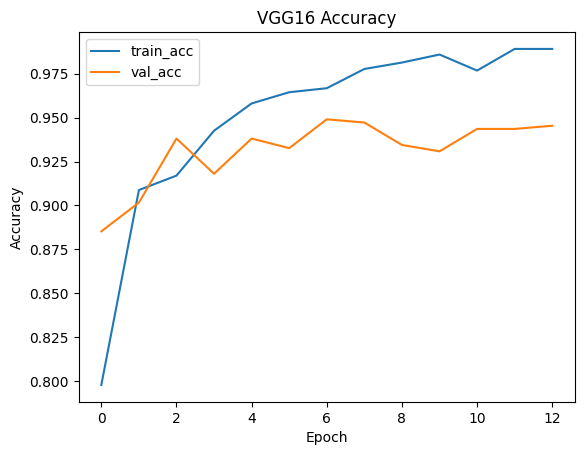

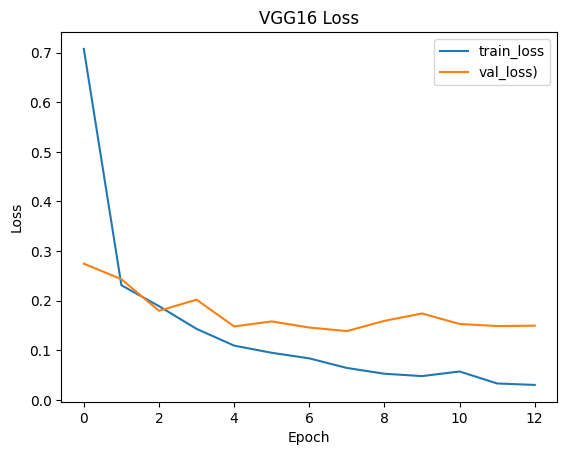

In [175]:
#plot the accuracy and the loss curve
plt.figure()
plt.plot(history_vgg16.history['accuracy'], label='train_acc')
plt.plot(history_vgg16.history['val_accuracy'], label='val_acc')
plt.title('VGG16 Accuracy'); plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.show()

plt.figure()
plt.plot(history_vgg16.history['loss'], label='train_loss')
plt.plot(history_vgg16.history['val_loss'], label='val_loss)')
plt.title('VGG16 Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.show()

# inception V3

This model employs InceptionV3, a high-performing convolutional neural network architecture pre-trained on ImageNet, as the backbone for transfer learning. InceptionV3 is chosen for its computational efficiency and multi-scale feature extraction capability — it processes information through parallel convolutional paths with different kernel sizes (1×1, 3×3, 5×5), allowing the model to capture both fine-grained and global visual patterns. This makes it more flexible than simpler architectures like VGG16 and often more parameter-efficient than DenseNet121.

Input images are dynamically resized to 299×299×3 (the native InceptionV3 input size) and preprocessed with the architecture’s own preprocess_input function to match the original ImageNet training distribution. The convolutional base is frozen (trainable=False) to preserve learned low-level features, while a new classification head is trained on top. The top layers include a GlobalAveragePooling2D layer for spatial aggregation, a Dropout(0.3) layer to reduce overfitting, and a Dense(num_classes, softmax) output layer for multi-class prediction.

The model is compiled with Adam(learning_rate=1e-3) optimizer, categorical_crossentropy loss, and accuracy as the evaluation metric. Training typically includes two adaptive callbacks:

1. EarlyStopping(patience=5, restore_best_weights=True) – stops training early if validation loss no longer improves.

2. ReduceLROnPlateau(patience=3, factor=0.5, verbose=1) – halves the learning rate when performance plateaus, refining convergence.

In [179]:
##InceptionV3
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
#data preprocessing and resize 
num_classes = y_train.shape[1]

inp = layers.Input(shape=(None, None, 3))
x = layers.Resizing(299, 299)(inp) #default size for InceptionV3
x = layers.Lambda(preprocess_input)(x)

# Backbone model create
base = InceptionV3(weights='imagenet', include_top=False, input_tensor=x)
base.trainable = False  #use the imagenet pre trained weight, so need to fix the weight non trainable 

h = layers.GlobalAveragePooling2D()(base.output)
h = layers.Dropout(0.3)(h) #add dropout to prevent overfitting
out = layers.Dense(num_classes, activation='softmax')(h)
model_iv3 = models.Model(inp, out)

# complie model
model_iv3.compile(optimizer=optimizers.Adam(1e-3),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

print(model_iv3.summary())

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 resizing_2 (Resizing)          (None, 299, 299, 3)  0           ['input_6[0][0]']                
                                                                                                  
 lambda_2 (Lambda)              (None, 299, 299, 3)  0           ['resizing_2[0][0]']             
                                                                                                  
 conv2d_94 (Conv2D)             (None, 149, 149, 32  864         ['lambda_2[0][0]']         

In [181]:
# callback and fit
cb = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(patience=3, factor=0.5, verbose=1)
]#same call back function used (early stopping and learning rate adjustment)
history_iv3 = model_iv3.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=25, batch_size=32,
    callbacks=cb, verbose=1
)

# evaluate
test_loss_iv3, test_acc_iv3 = model_iv3.evaluate(X_test, y_test, verbose=0)

best_epoch = np.argmax(history_iv3.history['val_accuracy'])
# find the Best epoch (Because using the early stopping )
best_train_acc  = history_iv3.history['accuracy'][best_epoch]
best_val_acc    = history_iv3.history['val_accuracy'][best_epoch]
best_train_loss = history_iv3.history['loss'][best_epoch]
best_val_loss   = history_iv3.history['val_loss'][best_epoch]

print("=== InceptionV3 Early-Stopped Performance ===")
print(f"Best Epoch: {best_epoch + 1}")
print(f"Training   Accuracy: {best_train_acc:.4f} | Loss: {best_train_loss:.4f}")
print(f"Validation Accuracy: {best_val_acc:.4f} | Loss: {best_val_loss:.4f}")
print(f"Test       Accuracy: {test_acc_iv3:.4f} | Loss: {test_loss_iv3:.4f}")

#store the result
perf_rows.append({
    'Model': 'InceptionV3',
    'Type': 'transfer',
    'Train_Accuracy': float(best_train_acc),
    'Val_Accuracy': float(best_val_acc),
    'Test_Accuracy': float(test_acc_iv3),
    'Train_Loss': float(best_train_loss),
    'Val_Loss': float(best_val_loss),
    'Test_Loss': float(test_loss_iv3)
})


Epoch 1/25
69/69 [==============================] - 8s 72ms/step - loss: 1.1263 - accuracy: 0.3490 - val_loss: 1.0786 - val_accuracy: 0.3279 - lr: 0.0010
Epoch 2/25
69/69 [==============================] - 4s 53ms/step - loss: 1.0591 - accuracy: 0.4407 - val_loss: 1.0316 - val_accuracy: 0.3862 - lr: 0.0010
Epoch 3/25
69/69 [==============================] - 4s 52ms/step - loss: 1.0304 - accuracy: 0.4909 - val_loss: 0.9855 - val_accuracy: 0.7268 - lr: 0.0010
Epoch 4/25
69/69 [==============================] - 4s 51ms/step - loss: 0.9934 - accuracy: 0.5502 - val_loss: 0.9651 - val_accuracy: 0.5647 - lr: 0.0010
Epoch 5/25
69/69 [==============================] - 4s 52ms/step - loss: 0.9701 - accuracy: 0.5908 - val_loss: 0.9240 - val_accuracy: 0.7268 - lr: 0.0010
Epoch 6/25
69/69 [==============================] - 4s 51ms/step - loss: 0.9354 - accuracy: 0.6323 - val_loss: 0.9098 - val_accuracy: 0.6721 - lr: 0.0010
Epoch 7/25
69/69 [==============================] - 3s 51ms/step - loss: 0.9

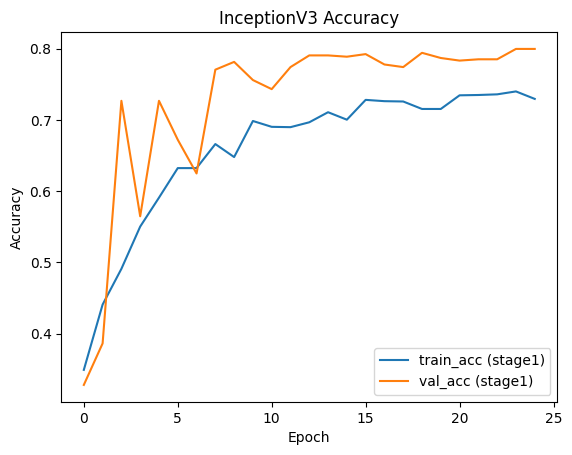

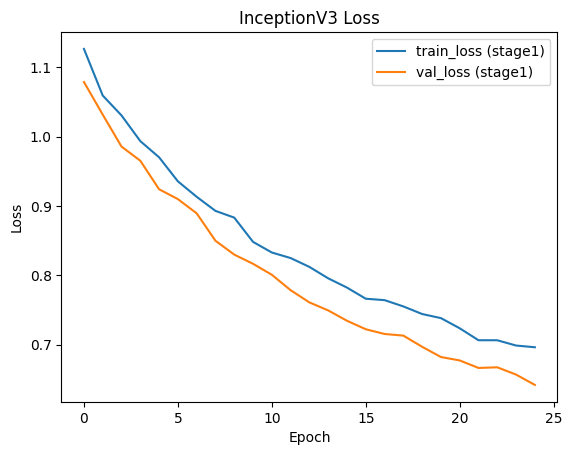

In [182]:
#visulization
epochs1 = range(len(history_iv3.history['accuracy']))
plt.figure()
plt.plot(epochs1, history_iv3.history['accuracy'], label='train_acc (stage1)')
plt.plot(epochs1, history_iv3.history['val_accuracy'], label='val_acc (stage1)')
plt.title('InceptionV3 Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.show()

plt.figure()
plt.plot(epochs1, history_iv3.history['loss'], label='train_loss (stage1)')
plt.plot(epochs1, history_iv3.history['val_loss'], label='val_loss (stage1)')
plt.title('InceptionV3 Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.show()


## DenseNet121

**Model Summary**

This model implements a transfer-learning pipeline based on DenseNet121 pre-trained on ImageNet. The base network serves as a fixed feature extractor while a lightweight custom classification head is trained on top. Input images are resized to 224×224 and normalized through DenseNet’s standard preprocess_input function.

After the convolutional backbone, a GlobalAveragePooling2D layer condenses spatial features, followed by a Dropout(0.3) layer for regularization and a Dense(num_classes, softmax) output layer for multi-class probability prediction. The model is compiled with Adam (learning rate = 1e-3), categorical cross-entropy loss, and accuracy as the evaluation metric.

**Training typically incorporates two key callbacks:**

1. ReduceLROnPlateau – automatically halves the learning rate when validation loss stops improving for several epochs (e.g., patience=3, factor=0.5), enabling finer optimization near minima.

2. EarlyStopping – terminates training when no validation improvement occurs for a specified patience period (e.g., 5 epochs) and restores the best weights to prevent overfitting.

In [147]:
##DenseNet121
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input

num_classes = y_train.shape[1] if y_train.ndim == 2 else int(y_train.max()) + 1

inp = layers.Input(shape=(None, None, 3))
x   = layers.Resizing(224, 224)(inp)                  # DenseNet121 default input size
x   = layers.Lambda(preprocess_input)(x)             

# Backbone model create
base = DenseNet121(weights='imagenet', include_top=False, input_tensor=x)
base.trainable = False #use the pre trained weight from imagenet

h   = layers.GlobalAveragePooling2D()(base.output)
h   = layers.Dropout(0.3)(h)
out = layers.Dense(num_classes, activation='softmax')(h)
model_dn = models.Model(inp, out)

# compile model
model_dn.compile(optimizer=optimizers.Adam(1e-3),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

print(model_dn.summary())

29084464/29084464 [==============================] - 0s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 resizing_1 (Resizing)          (None, 224, 224, 3)  0           ['input_4[0][0]']                
                                                                                                  
 lambda_1 (Lambda)              (None, 224, 224, 3)  0           ['resizing_1[0][0]']             
                                                                                                  
 zero_padding2d (ZeroPaddin

In [148]:
# callback and fit
cb = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(patience=3, factor=0.5, verbose=1)
]  #same callback used here to prevent overfitting and divergence 
history_dn = model_dn.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=25, batch_size=32,
    callbacks=cb, verbose=1
)

# evaluate
test_loss_dn, test_acc_dn = model_dn.evaluate(X_test, y_test, verbose=0)
print(f"[DenseNet121] Test Accuracy: {test_acc_dn:.4f}")

# report
best_epoch = np.argmax(history_dn.history['val_accuracy'])
# find the best epoch (because earlystoppig is used)
best_train_acc  = history_dn.history['accuracy'][best_epoch]
best_val_acc    = history_dn.history['val_accuracy'][best_epoch]
best_train_loss = history_dn.history['loss'][best_epoch]
best_val_loss   = history_dn.history['val_loss'][best_epoch]

print("=== DenseNet121 Early-Stopped Performance ===")
print(f"Best Epoch: {best_epoch + 1}")
print(f"Training   Accuracy: {best_train_acc:.4f} | Loss: {best_train_loss:.4f}")
print(f"Validation Accuracy: {best_val_acc:.4f} | Loss: {best_val_loss:.4f}")
print(f"Test       Accuracy: {test_acc_dn:.4f} | Loss: {test_loss_dn:.4f}")

#store the model result
perf_rows.append({
    'Model': 'DenseNet121',
    'Type': 'transfer',
    'Train_Accuracy': float(best_train_acc),
    'Val_Accuracy': float(best_val_acc),
    'Test_Accuracy': float(test_acc_dn),
    'Train_Loss': float(best_train_loss),
    'Val_Loss': float(best_val_loss),
    'Test_Loss': float(test_loss_dn)
})

Epoch 1/25
69/69 [==============================] - 7s 73ms/step - loss: 1.1472 - accuracy: 0.3449 - val_loss: 1.0866 - val_accuracy: 0.4080 - lr: 0.0010
Epoch 2/25
69/69 [==============================] - 4s 54ms/step - loss: 1.1080 - accuracy: 0.3622 - val_loss: 1.0653 - val_accuracy: 0.5428 - lr: 0.0010
Epoch 3/25
69/69 [==============================] - 4s 53ms/step - loss: 1.0812 - accuracy: 0.4037 - val_loss: 1.0458 - val_accuracy: 0.5483 - lr: 0.0010
Epoch 4/25
69/69 [==============================] - 4s 54ms/step - loss: 1.0594 - accuracy: 0.4457 - val_loss: 1.0323 - val_accuracy: 0.4135 - lr: 0.0010
Epoch 5/25
69/69 [==============================] - 4s 53ms/step - loss: 1.0372 - accuracy: 0.4781 - val_loss: 1.0109 - val_accuracy: 0.5974 - lr: 0.0010
Epoch 6/25
69/69 [==============================] - 4s 53ms/step - loss: 1.0208 - accuracy: 0.5041 - val_loss: 0.9994 - val_accuracy: 0.5847 - lr: 0.0010
Epoch 7/25
69/69 [==============================] - 4s 53ms/step - loss: 1.0

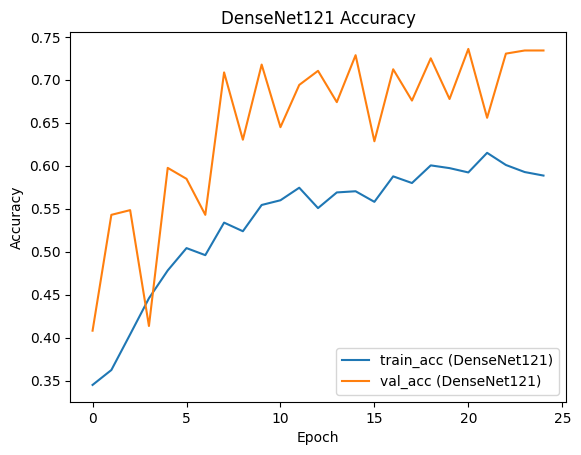

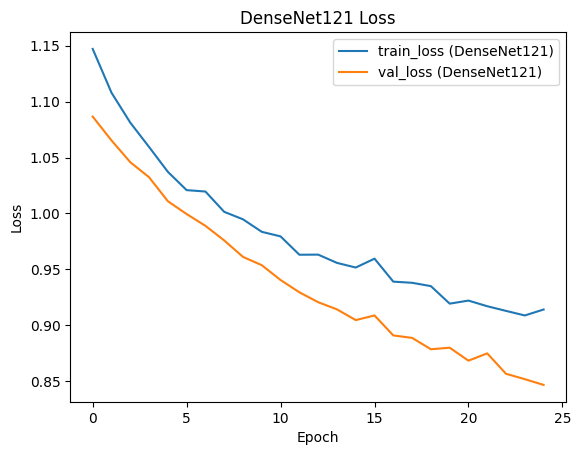

In [150]:
# visualization
epochs1 = range(len(history_dn.history['accuracy']))
plt.figure()
plt.plot(epochs1, history_dn.history['accuracy'],     label='train_acc (DenseNet121)')
plt.plot(epochs1, history_dn.history['val_accuracy'], label='val_acc (DenseNet121)')
plt.title('DenseNet121 Accuracy'); plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.show()

plt.figure()
plt.plot(epochs1, history_dn.history['loss'],     label='train_loss (DenseNet121)')
plt.plot(epochs1, history_dn.history['val_loss'], label='val_loss (DenseNet121)')
plt.title('DenseNet121 Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.show()

# Model comparison 
**pervious testing are all using the same test data set**

,Model,Type,Train_Accuracy,Val_Accuracy,Test_Accuracy,Train_Loss,Val_Loss,Test_Loss
0,BaselineCNN,baseline,0.976277,0.945355,0.928737,0.076183,0.230559,0.193557
1,ResNet,transfer,0.927007,0.901639,0.934160,0.195937,0.230559,0.159828
2,VGG16,transfer,1.000000,0.952641,0.962820,0.008862,0.139908,0.104191
3,InceptionV3,transfer,0.774635,0.826958,0.814872,0.602524,0.547989,0.534623
4,DenseNet121,transfer,0.592153,0.735883,0.683966,0.921994,0.868250,0.873892


,Model,Train_Accuracy,Val_Accuracy,Test_Accuracy,Train_Loss,Val_Loss,Test_Loss,Optimizer,LR,Batch
0,VGG16,1.000000,0.952641,0.962820,0.008862,0.139908,0.104191,Adam,0.0003,32.0
1,ResNet,0.927007,0.901639,0.934160,0.195937,0.230559,0.159828,NaN,NaN,NaN
2,BaselineCNN,0.976277,0.945355,0.928737,0.076183,0.230559,0.193557,Adam,0.0010,32.0
3,InceptionV3,0.774635,0.826958,0.814872,0.602524,0.547989,0.534623,Adam,0.0003,32.0
4,DenseNet121,0.592153,0.735883,0.683966,0.921994,0.868250,0.873892,Adam,0.0003,32.0


 Best model: VGG16 (Test Accuracy = 0.9628)


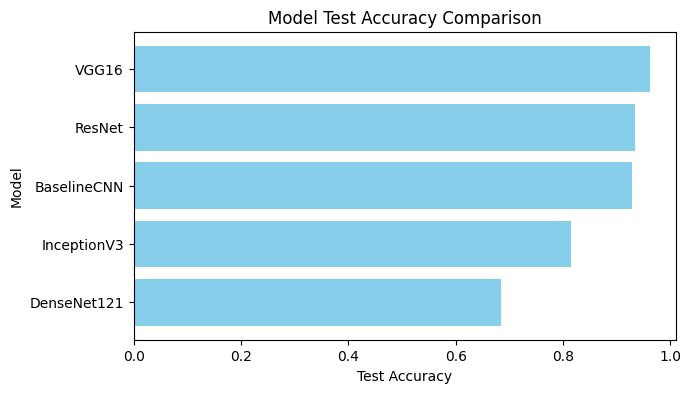

In [167]:
import pandas as pd
import matplotlib.pyplot as plt

# performance df
perf_df = pd.DataFrame(perf_rows)
display(perf_df)

# sort by test acc
cols = ['Model', 'Train_Accuracy', 'Val_Accuracy', 'Test_Accuracy', 
        'Train_Loss', 'Val_Loss', 'Test_Loss']
perf_summary = perf_df[cols].sort_values('Test_Accuracy', ascending=False).reset_index(drop=True)

# Hypyer parameter
hparams = pd.DataFrame([
    ['BaselineCNN', 'Adam', 1e-3, 32],
    ['ResNet50', 'Adam', 1e-4, 32],
    ['VGG16', 'Adam', 3e-4, 32],
    ['InceptionV3', 'Adam', 3e-4, 32],
    ['DenseNet121', 'Adam', 3e-4, 32],
], columns=['Model','Optimizer','LR','Batch']) #check every model's hyperparameter and make them into a dataframe 
perf_final = perf_summary.merge(hparams, on='Model', how='left') #merge two dfs
display(perf_final)

# find best model (use the test accuracy)
best = perf_summary.iloc[0]
print(f" Best model: {best['Model']} (Test Accuracy = {best['Test_Accuracy']:.4f})")

# plot the comparison of test accurancy 
plt.figure(figsize=(7,4))
plt.barh(perf_summary['Model'], perf_summary['Test_Accuracy'], color='skyblue')
plt.xlabel('Test Accuracy'); plt.ylabel('Model')
plt.title('Model Test Accuracy Comparison')
plt.gca().invert_yaxis()
plt.show()


**The best model is VGG16 with 0.962820	test accuracy**

As summarized in above table, the five models showed clear performance differences on the same test set. VGG16 achieved the highest test accuracy (0.9628) and lowest test loss (0.104), indicating the most reliable generalization. ResNet50 and Baseline CNN followed with accuracies around 0.93, while InceptionV3 (0.81) and DenseNet121 (0.68) performed worse.

Models with moderate depth and balanced fine-tuning, such as VGG16 and ResNet50, converged more stably and generalized better than deeper ones like InceptionV3 or DenseNet121, which required longer training and showed signs of underfitting. The Baseline CNN performed decently but lacked the representational power of pretrained models.

Overall, transfer-learning architectures with well-controlled complexity proved most effective under our limited training schedule, while deeper networks were less efficient and slower to converge.

**About epoch comparation：**
We did not directly compare the number of epochs among models, because each architecture was defined and trained under different configurations and convergence speeds. Some models (e.g., InceptionV3, DenseNet121) have deeper structures and require more iterations to converge, while others reach optimal validation accuracy earlier. Therefore, **the number of epochs itself is not a fair indicator of performance or efficiency in this context**. Our early-stopping strategy ensured that each model was evaluated at its best validation performance rather than its final epoch.

**But the best epoch of our training for each model are listed in the graphs below.（the vertical line）**

### Accurancy and Loss Plot 

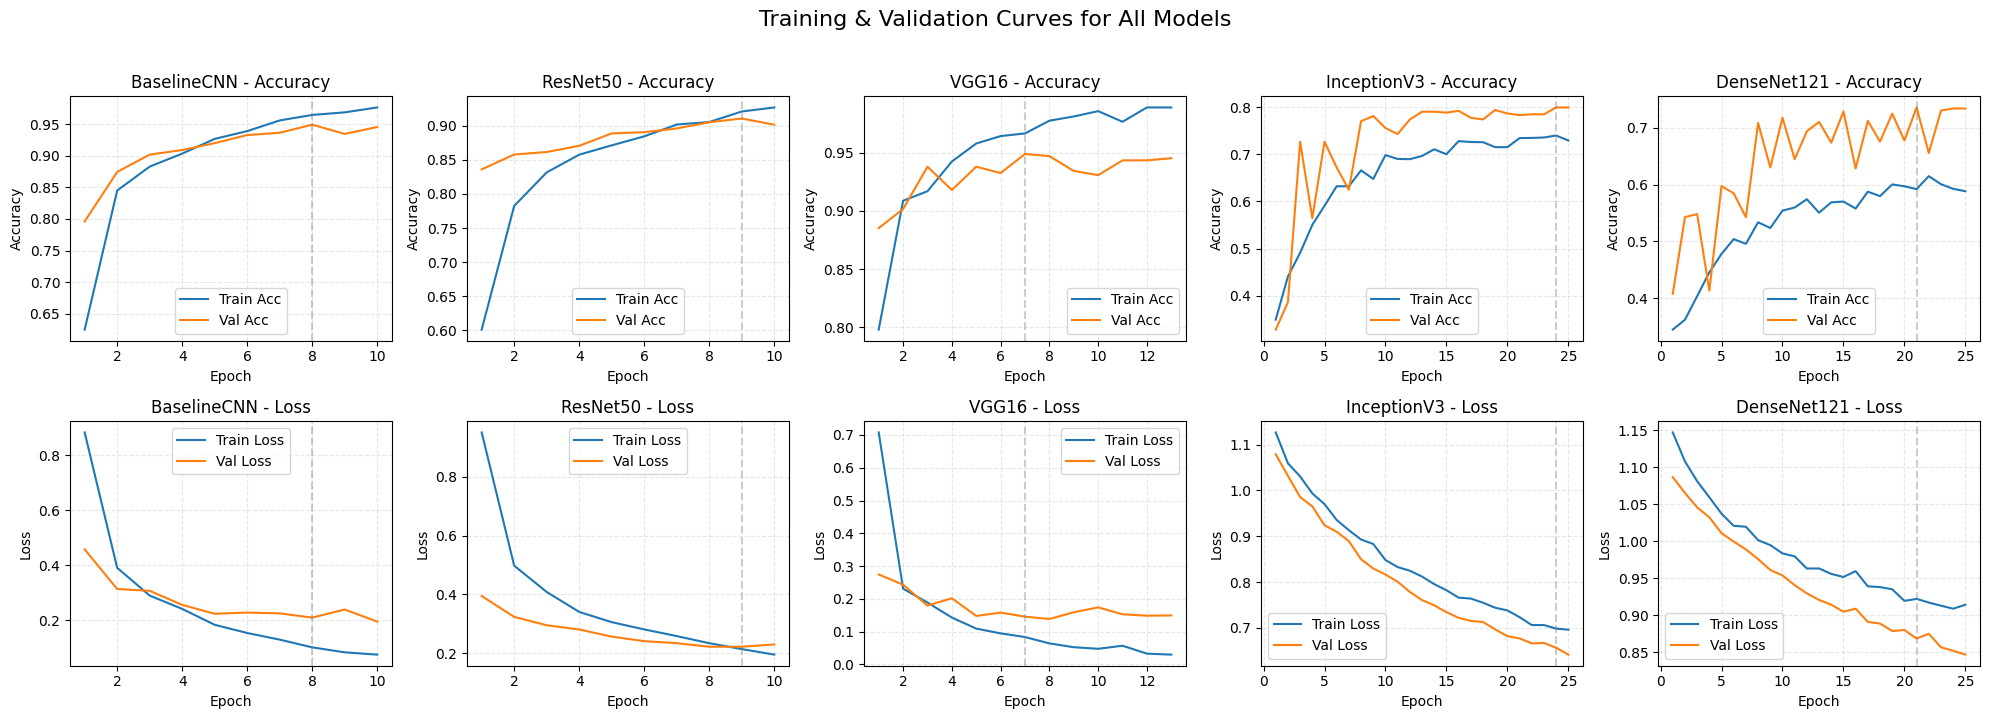

In [190]:
# plot in one
model_names = list(histories.keys())
n_models = len(model_names)

#big plot for all models
fig, axes = plt.subplots(2, n_models, figsize=(4*n_models, 7))
fig.suptitle("Training & Validation Curves for All Models", fontsize=16, y=1.02)

for i, (name, hist) in enumerate(histories.items()):
    H = getattr(hist, "history", {})
    acc, val_acc = H.get("accuracy", []), H.get("val_accuracy", [])
    loss, val_loss = H.get("loss", []), H.get("val_loss", [])
    epochs = range(1, max(len(acc), len(val_acc), len(loss), len(val_loss)) + 1)

    # --- Accuracy subplot ---
    ax = axes[0, i] if n_models > 1 else axes[0]
    if acc:     ax.plot(epochs, acc, label="Train Acc")
    if val_acc: ax.plot(epochs, val_acc, label="Val Acc")
    if val_acc:
        best_ep = np.argmax(val_acc) + 1
        ax.axvline(best_ep, ls="--", alpha=0.4, color='gray')
    ax.set_title(f"{name} - Accuracy")
    ax.set_xlabel("Epoch"); ax.set_ylabel("Accuracy")
    ax.grid(ls="--", alpha=0.3)
    ax.legend()

    # --- Loss subplot ---
    ax = axes[1, i] if n_models > 1 else axes[1]
    if loss:     ax.plot(epochs, loss, label="Train Loss")
    if val_loss: ax.plot(epochs, val_loss, label="Val Loss")
    if val_acc:
        ax.axvline(best_ep, ls="--", alpha=0.4, color='gray')
    ax.set_title(f"{name} - Loss")
    ax.set_xlabel("Epoch"); ax.set_ylabel("Loss")
    ax.grid(ls="--", alpha=0.3)
    ax.legend()

plt.tight_layout()
plt.show()


# Data Augmentation

For medical images (chest X-rays), we use CONSERVATIVE augmentation:
- ±5 degrees small rotations to account for patient positioning
- ±5% small shifts for horizontal and vertical translations
- 95%-105% small zoom to simulate distance variations
- NO horizontal/vertical flips
- NO heavy distortions

This increases dataset size and improves model generalization without
compromising the clinical validity of the images.

In [152]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Define augmentation parameters for medical images
medical_augmentation = ImageDataGenerator(
    rotation_range=5,           # Small rotation (+-5 degrees)
    width_shift_range=0.05,     # Horizontal shift (+-5%)
    height_shift_range=0.05,    # Vertical shift (+-5%)
    zoom_range=0.05,            # Zoom in&out (95%-105%)
    horizontal_flip=False,      # NO flip
    vertical_flip=False,        # NO vertical flip
    fill_mode='nearest',        # Fill empty pixels with nearest values
    validation_split=0.2        # 20% for validation
)

# No augmentation for test set
test_datagen = ImageDataGenerator()

**Visualize Augmented Samples**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.003937008..0.992126].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.003937008..0.988189].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.003937008..0.9860631].


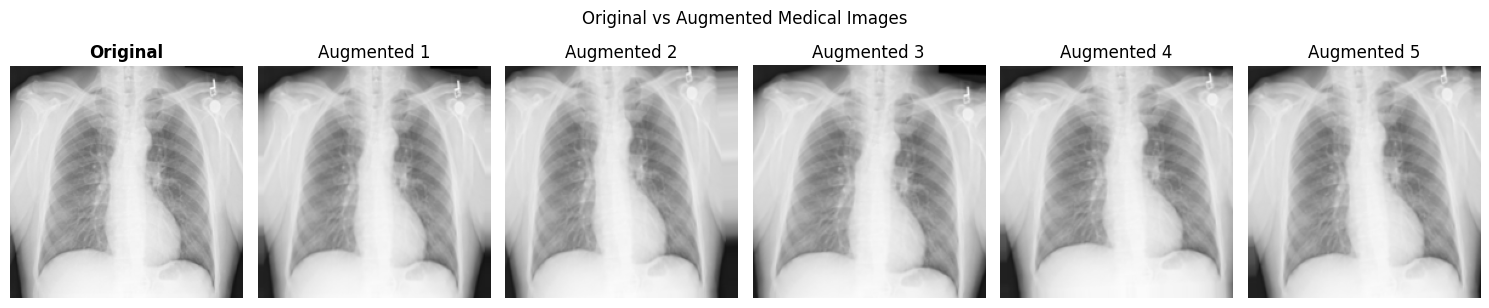

In [154]:
# Create augmentation generator for visualization
vis_augmentation = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.05,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode='nearest'
)

# Take a look at a sample image from training set
sample_image = X_train[0:1]

# Generate augmented versions
plt.figure(figsize=(15, 3))

# Original image
plt.subplot(1, 6, 1)
plt.imshow(sample_image[0])
plt.title('Original', fontweight='bold')
plt.axis('off')

# Generate 5 augmented versions
for i in range(5):
    aug_iter = vis_augmentation.flow(sample_image, batch_size=1)
    aug_image = next(aug_iter)[0]

    plt.subplot(1, 6, i+2)
    plt.imshow(aug_image)
    plt.title(f'Augmented {i+1}')
    plt.axis('off')

plt.suptitle('Original vs Augmented Medical Images', y=1.02)
plt.tight_layout()
plt.show()

**Create CNN Model with Augmentation**

We'll use the same architecture as the baseline CNN, but train it with augmented data.

In [198]:
# Create the same baseline CNN model
def create_baseline_cnn_augmented(input_shape=(192, 192, 3), num_classes=3):
    """
    Same CNN architecture to baseline model.
    """

    model = Sequential(name='Baseline_CNN_Augmented')

    # First Convolutional Block
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu',
                     padding='same', input_shape=input_shape, name='conv1'))
    model.add(MaxPooling2D(pool_size=(2, 2), name='pool1'))
    model.add(Dropout(0.25, name='dropout1'))

    # Second Convolutional Block
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu',
                     padding='same', name='conv2'))
    model.add(MaxPooling2D(pool_size=(2, 2), name='pool2'))
    model.add(Dropout(0.25, name='dropout2'))

    # Third Convolutional Block
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu',
                     padding='same', name='conv3'))
    model.add(MaxPooling2D(pool_size=(2, 2), name='pool3'))
    model.add(Dropout(0.25, name='dropout3'))

    # Flatten and fully connected layers
    model.add(Flatten(name='flatten'))
    model.add(Dense(256, activation='relu', name='fc1'))
    model.add(Dropout(0.5, name='dropout4'))
    model.add(Dense(num_classes, activation='softmax', name='output'))

    return model

In [200]:
# Create the augmented CNN
cnn_augmented = create_baseline_cnn_augmented(input_shape=(192, 192, 3), num_classes=3)

In [201]:
# Compile
cnn_augmented.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display
cnn_augmented.summary()

Model: "Baseline_CNN_Augmented"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 192, 192, 32)      896       
                                                                 
 pool1 (MaxPooling2D)        (None, 96, 96, 32)        0         
                                                                 
 dropout1 (Dropout)          (None, 96, 96, 32)        0         
                                                                 
 conv2 (Conv2D)              (None, 96, 96, 64)        18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 48, 48, 64)        0         
                                                                 
 dropout2 (Dropout)          (None, 48, 48, 64)        0         
                                                                 
 conv3 (Conv2D)              (None, 48, 48, 

**Train CNN with Augmented Data**

In [203]:
# Callbacks
callbacks_augmented = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
]

# Train with augmented data using flow()
history_cnn_augmented = cnn_augmented.fit(
    medical_augmentation.flow(X_train, y_train, batch_size=32, subset='training'),
    validation_data=medical_augmentation.flow(X_train, y_train, batch_size=32, subset='validation'),
    epochs=10,
    callbacks=callbacks_augmented,
    verbose=1
)

Epoch 1/10
69/69 [==============================] - 15s 215ms/step - loss: 1.2392 - accuracy: 0.5732 - val_loss: 0.6065 - val_accuracy: 0.6405 - lr: 0.0010
Epoch 2/10
69/69 [==============================] - 14s 203ms/step - loss: 0.5319 - accuracy: 0.7246 - val_loss: 0.5164 - val_accuracy: 0.7336 - lr: 0.0010
Epoch 3/10
69/69 [==============================] - 14s 202ms/step - loss: 0.4611 - accuracy: 0.7715 - val_loss: 0.5186 - val_accuracy: 0.7536 - lr: 0.0010
Epoch 4/10
69/69 [==============================] - 14s 203ms/step - loss: 0.4302 - accuracy: 0.7953 - val_loss: 0.4266 - val_accuracy: 0.8230 - lr: 0.0010
Epoch 5/10
69/69 [==============================] - 16s 236ms/step - loss: 0.3940 - accuracy: 0.8313 - val_loss: 0.3967 - val_accuracy: 0.8577 - lr: 0.0010
Epoch 6/10
69/69 [==============================] - 14s 203ms/step - loss: 0.3501 - accuracy: 0.8627 - val_loss: 0.4115 - val_accuracy: 0.8376 - lr: 0.0010
Epoch 7/10
69/69 [==============================] - 14s 202ms/st

**Evaluate CNN with Augmentation**

In [205]:
# Evaluate test set
test_loss_augmented, test_acc_augmented = cnn_augmented.evaluate(X_test, y_test, verbose=0)

print(f"Test Loss:     {test_loss_augmented:.4f}")
print(f"Test Accuracy: {test_acc_augmented:.4f} ({test_acc_augmented*100:.2f}%)")

# Final training and validation accuracy and loss
final_train_acc_aug = history_cnn_augmented.history['accuracy'][-1]
final_train_loss_aug = history_cnn_augmented.history['loss'][-1]
final_val_acc_aug = history_cnn_augmented.history['val_accuracy'][-1]
final_val_loss_aug = history_cnn_augmented.history['val_loss'][-1]

print(f"\nFinal Training Accuracy:   {final_train_acc_aug:.4f} ({final_train_acc_aug*100:.2f}%)")
print(f"Final Validation Accuracy: {final_val_acc_aug:.4f} ({final_val_acc_aug*100:.2f}%)")

Test Loss:     0.2785
Test Accuracy: 0.9032 (90.32%)

Final Training Accuracy:   0.8919 (89.19%)
Final Validation Accuracy: 0.8832 (88.32%)


**Visualize Augmented CNN Training History**

Training curves for CNN with augmentation

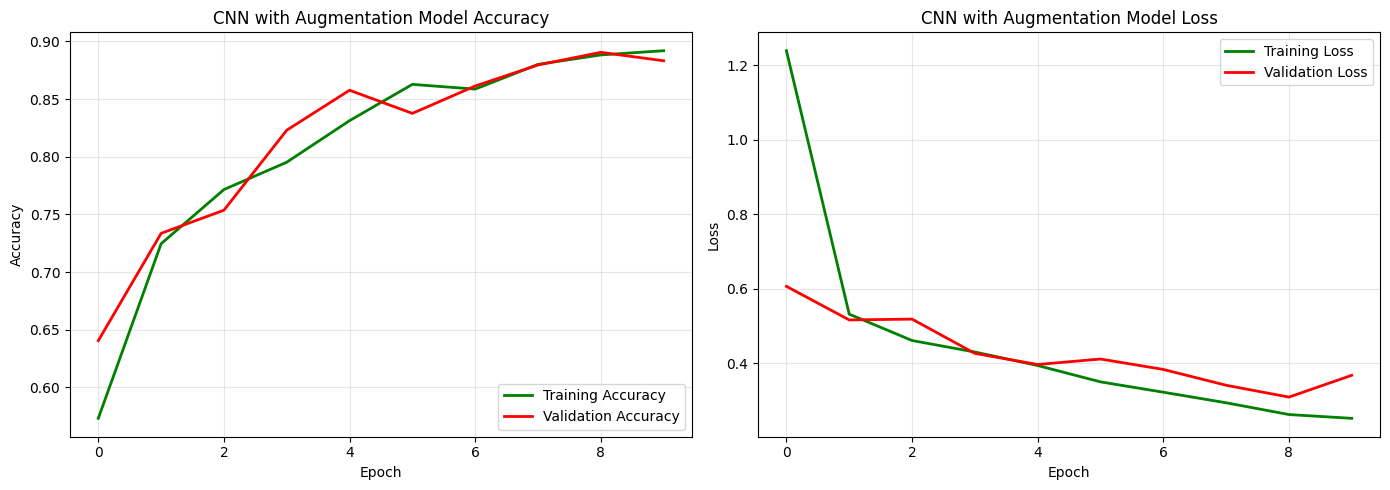

In [207]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training & validation accuracy
axes[0].plot(history_cnn_augmented.history['accuracy'], label='Training Accuracy', linewidth=2, color='green')
axes[0].plot(history_cnn_augmented.history['val_accuracy'], label='Validation Accuracy', linewidth=2, color='red')
axes[0].set_title('CNN with Augmentation Model Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend(loc='lower right')
axes[0].grid(True, alpha=0.3)

# Training & validation loss
axes[1].plot(history_cnn_augmented.history['loss'], label='Training Loss', linewidth=2, color='green')
axes[1].plot(history_cnn_augmented.history['val_loss'], label='Validation Loss', linewidth=2, color='red')
axes[1].set_title('CNN with Augmentation Model Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Interpretability & Insights

### Best model: VGG16.
By both accuracy and loss, VGG16 is the clear winner (Test Acc = 0.9628, Loss = 0.104). ResNet50 and Baseline CNN follow (~0.93 acc; losses 0.160 and 0.194), while InceptionV3 (0.815; 0.535) and DenseNet121 (0.684; 0.874) lag behind.

### Why VGG16 wins (with evidence):

- Stable generalization: Train vs. val gap is small (Train Acc 1.00 vs. Val Acc 0.953), and the learning curves rise smoothly without late-epoch divergence—consistent with good regularization and early stopping.

- Right complexity for our data/epochs: VGG16’s simple 3×3 conv blocks transfer well with partial fine-tuning. Deeper nets (InceptionV3/DenseNet121) likely needed more compute/epochs to reach their potential; their curves plateau early (underfitting) and keep higher validation loss.

- Efficiency–performance trade-off: Compared with DenseNet121/InceptionV3, VGG16 reached higher accuracy with less training instability and lower test loss, making it the most reliable choice under our constraints.

### Practical utility of the best model (VGG16)

### Who benefits

Practitioners who need high accuracy with predictable training: teaching labs, small research groups, and product teams with limited GPU time.

Domain analysts/clinicians (if this is medical imaging): teams needing a strong pretrained backbone that is easy to validate and monitor.

### Real-world scenarios

Screening & triage: high-recall pre-filtering to flag likely positives before expert review.

Quality control pipelines: stable feature extractor for consistent batch inference.

Dataset labeling/active learning: reliable pseudo-labels to prioritize uncertain samples.

Edge/near-real-time inference (light servers): VGG16 is heavier than MobileNet but simpler/more predictable than very deep nets; with pruning/INT8 it can meet latency targets.

### Conclusion
Given the metrics (highest test accuracy, lowest test loss) and the smooth, well-behaved training curves, VGG16 offers the best balance of accuracy, stability, and practicality for our current data size and compute budget.